In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [205]:
file_path = 'credit_risk_dataset.csv'
df = pd.read_csv(file_path)

In [206]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [208]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [209]:
print('Количество погашеных кредитов с неизвестной ставкой:', df.loc[(df['loan_int_rate'].isna()) & (df['loan_status'] == 0)].shape[0]/ df.shape[0])

Количество погашеных кредитов с неизвестной ставкой: 0.07587244099321691


In [211]:
df = df.loc[(df['loan_int_rate'].notna()) | (df['loan_status'] == 1)]

Соответственно, можно удалить эти строки, они составляют 7% от всего датасета и являются хорошими кредитами (со статусом 0).

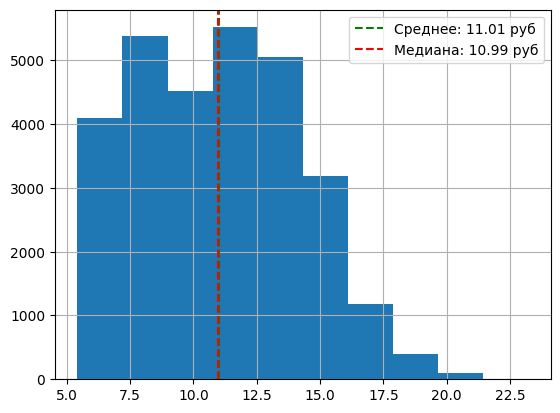

In [212]:
df['loan_int_rate'].hist()
median_price = df['loan_int_rate'].median()
mean_price = df['loan_int_rate'].mean()
plt.axvline(mean_price, color='green', linestyle='--', label=f'Среднее: {mean_price:.2f} руб')

plt.axvline(median_price, color='red', linestyle='--', label=f'Медиана: {median_price:.2f} руб')
plt.legend()

Посмотрим распределение процентной ставки, также убеждаемся, что выбросов нет.

In [213]:
df['loan_int_rate'] = df['loan_int_rate'].fillna(df.groupby('loan_grade')['loan_int_rate'].transform('mean'))

Заполним неoпределенные значения процентной ставки кредитов со статусом 1 средними показателями процентной ставки в соответствии с категорией заемщика.

In [214]:
print('Отношение person_emp_length без значений ко всему дататсету',df.loc[df['person_emp_length'].isna()].shape[0]/df.shape[0])

Отношение person_emp_length без значений ко всему дататсету 0.028164336244976586


In [215]:
df.dropna(subset='person_emp_length', inplace=True)

  Так как трудовой стаж сложно заменить приближенными значениями, и количество строк с неопределенными значениями составляют всего два процента от общего количесвта, наиболее рациональное решение - удалить эти строки

In [216]:
df.isna().sum().sum()

np.int64(0)

Таким образом, получили датасет без строк с неопределенными значениями.

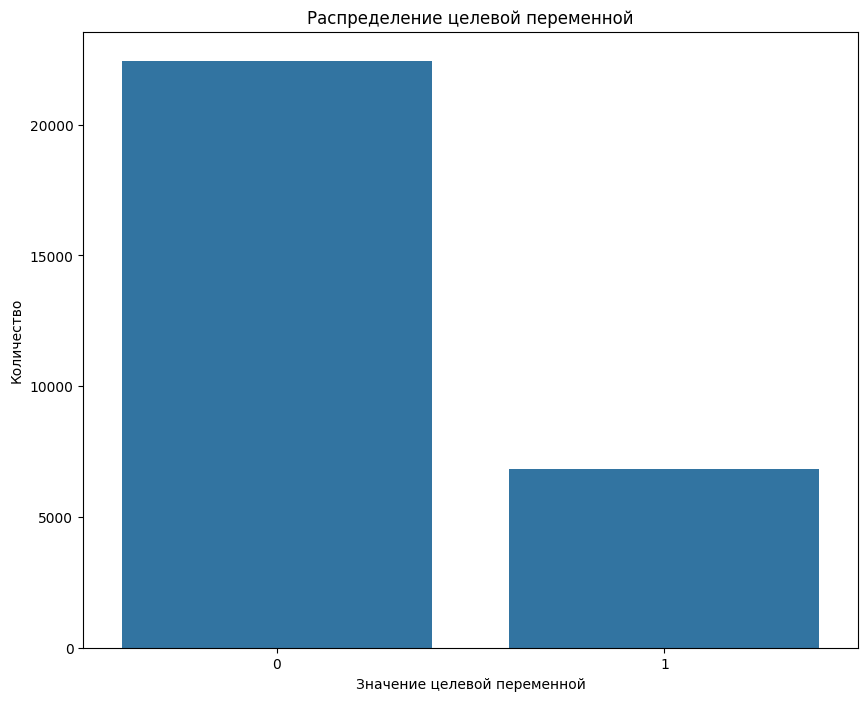

In [217]:
top_dep_cities = df['loan_status'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=top_dep_cities.index, y=top_dep_cities.values)

plt.title('Распределение целевой переменной')
plt.ylabel('Количество')
plt.xlabel('Значение целевой переменной')
plt.show()

Количество непогашенных займов составляет приблизительно четверть от общего количества, в связи с этим стоит рассмотреть факторы, повлиявшие на такой результат.

EDA

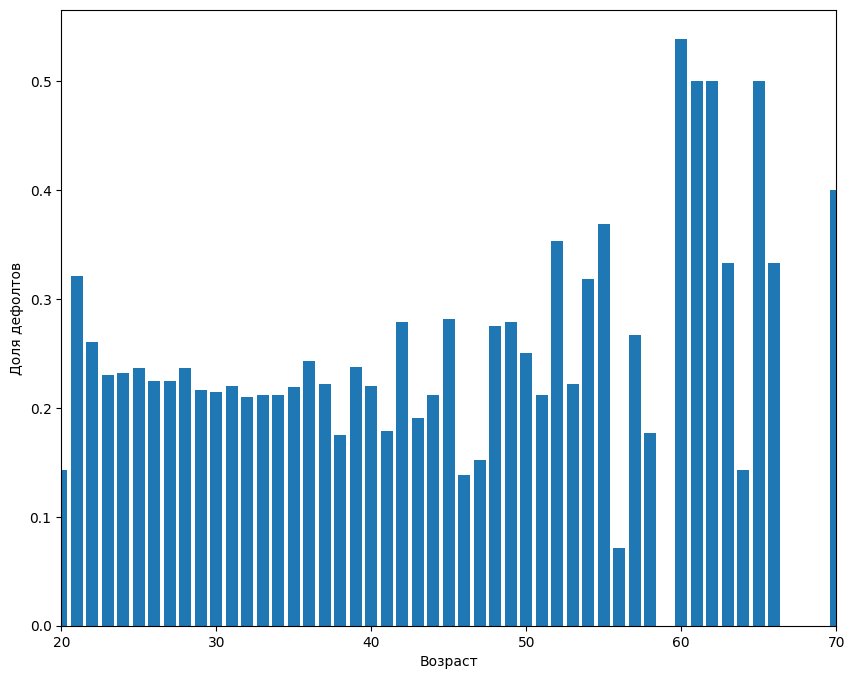

In [218]:
fig = df.groupby('person_age')['loan_status'].mean().reset_index()
plt.figure(figsize=(10,8))
plt.bar(fig['person_age'], fig['loan_status'])
plt.xlim(fig.loc[fig['loan_status']>0, 'person_age'].min(), fig.loc[fig['loan_status']>0, 'person_age'].max())
plt.xlabel('Возраст')
plt.ylabel('Доля дефолтов')
plt.show()

Как видно из графика: в среднем наибольшая ответственность за выполнение обязательств встречается среди возрастов 20-40 лет, тогда как с повышением возраста тенденция увеличивается в сторону дефолта.

/tmp/ipython-input-2685471690.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby('income_bin')['loan_status'].mean()


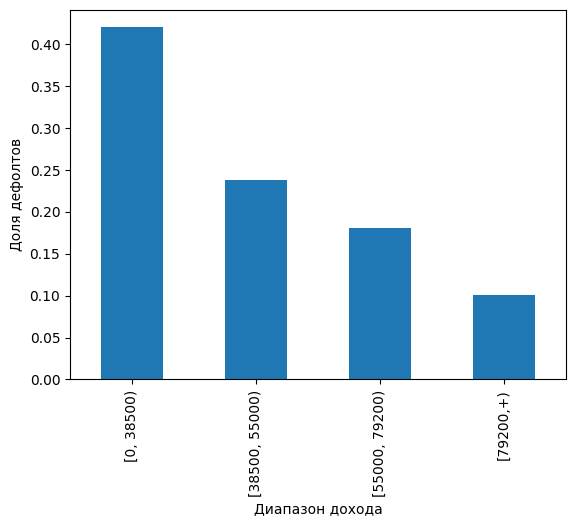

In [219]:
bins = [0, 38500, 55000, 79200, df['person_income'].max()]
labels = ['[0, 38500)', '[38500, 55000)', '[55000, 79200)', '[79200,+)']

df['income_bin'] = pd.cut(df['person_income'], bins=bins, labels=labels, right=False)
default_rate = df.groupby('income_bin')['loan_status'].mean()
default_rate.plot(kind='bar')
plt.ylabel('Доля дефолтов')
plt.xlabel('Диапазон дохода')
plt.show()

Результат графика свидетельсвует о том, что в среднем величина дохода напрямую связна с долей выполнения кредитных обязательств. Чем меньше доход - тем больше доля дефолтов.

/tmp/ipython-input-1204768087.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate=df.groupby('amnt_bin')['loan_status'].mean()


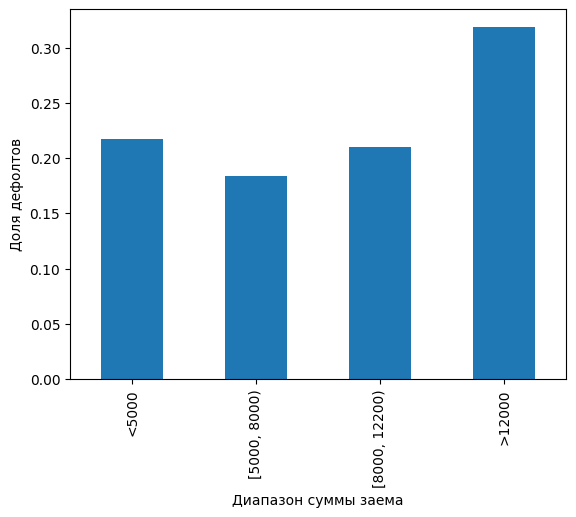

In [220]:
bins = [df['loan_amnt'].min(), 5000.00,	8000.00,	12200.00,	 df['loan_amnt'].max()]
labels = ['<5000', '[5000, 8000)', '[8000, 12200)', '>12000']
df['amnt_bin'] = pd.cut(df['loan_amnt'], bins=bins, labels=labels, right=False)
default_rate=df.groupby('amnt_bin')['loan_status'].mean()
default_rate.plot(kind='bar')
plt.ylabel('Доля дефолтов')
plt.xlabel('Диапазон суммы заема')
plt.show()

Согласно графику как и ожидалось наибольшая доля дефолтов среди диапазона наибольших сумм заема. В целом тенденция восходящая, начиная с суммы размером 5000. Однако для сумм меньше 5000 доля дефолтов меньше только, чем для диапазона с наибольшей суммой.

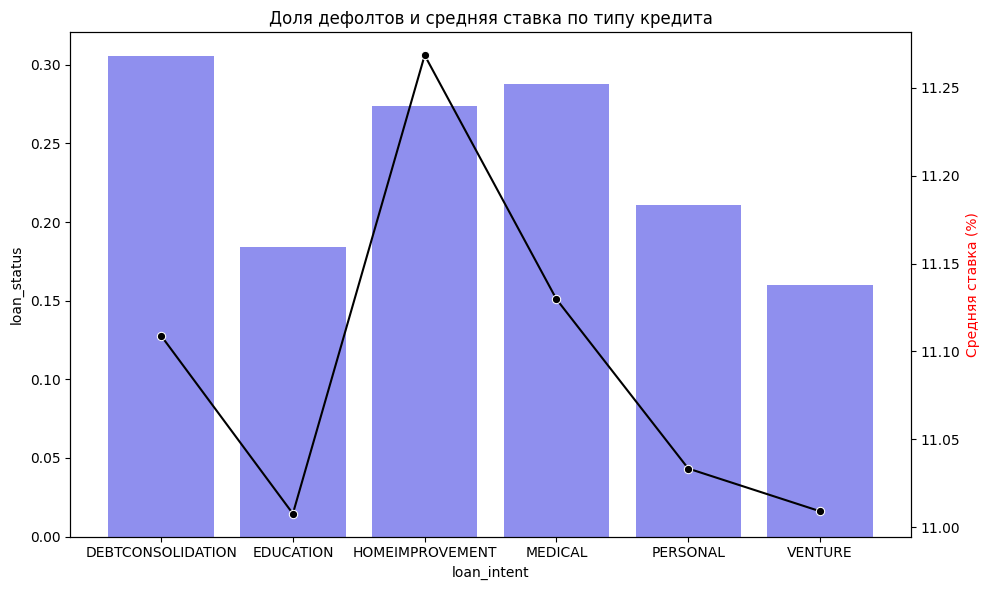

In [221]:
df_grouped = df.groupby('loan_intent', as_index=False).agg({
    'loan_status': 'mean',
    'loan_int_rate': 'mean'
})
plt.figure(figsize=(10,6))


sns.barplot(data=df_grouped, x='loan_intent', y='loan_status', color='blue', alpha=0.5)


ax2 = plt.twinx()
sns.lineplot(data=df_grouped, x='loan_intent', y='loan_int_rate', color='black', marker='o', ax=ax2)

plt.title('Доля дефолтов и средняя ставка по типу кредита')
plt.xlabel('Цель займа')
plt.ylabel('Доля дефолтов', color='blue')
ax2.set_ylabel('Средняя ставка (%)', color='red')

plt.tight_layout()
plt.show()

Из графика видно, что наиболее дефолтные цели кредитования: консолидация долга, медицина, ремонт жилища. Также для некоторых статей наблюдается зависимость: меньшая процентная ставка влечет меньшую долю дефолта.